In [90]:
from brian2 import *
from pulse2percept.stimuli import MonophasicPulse
import pulse2percept as p2p
import numpy as np
from pulse2percept.stimuli import BiphasicPulse
plt.rcParams['figure.dpi'] = 300
import time

%matplotlib inline

In [71]:
start_scope()
g_Na = 50*msiemens/cm**2
g_Ca = 2.2*msiemens/cm**2
g_K = 12.0*msiemens/cm**2
g_A = 36.0*msiemens/cm**2
gkca = 0.05*msiemens/cm**2
g_L = 0.05*msiemens/cm**2
C_m = 1.0*uF/cm**2
V_Na = 35.0*mV
V_K = -75.0*mV
V_L= -60.0*mV
Ca_D= 0.001*mM
Ca_E = 1.2*mM

In [72]:
from pulse2percept.utils.constants import DT
from pulse2percept.stimuli import Stimulus
import numpy as np
import matplotlib.pyplot as plt
class SinusoidalPulse(Stimulus):

    def __init__(self, amp, freq, phase, stim_dur, n_levels=50, dt=0.01):
        """Sinusoidal pulse

        Parameters
        ----------
        amp : float
            Maximum stimulus amplitude (uA)
        freq : float
            Ordinary frequency of the sine wave (Hz)
        phase : float
            Phase of the sine wave (rad)
        stim_dur : float
            Stimulus duration (ms)
        n_levels : int, optional, default: 5
            Number of discretization levels
        dt : float, optional, default: 0.001
            Smallest time step (ms)
        """
        #Sine Wave
        t = np.arange(0, stim_dur + dt / 2, dt)
        #sin1*pi*
        x = np.sin(2 * np.pi * freq * t + phase)
        # Converting to get data values
        levels = np.linspace(-1, 1, num=n_levels)
        data = levels[np.argmin(np.abs(x[:, np.newaxis] - levels), axis=1)]
        # single electrode:
        data = amp * data.reshape((1, -1))
        # Call the Stimulus constructor:
        super(SinusoidalPulse, self).__init__(data, time=t, compress=True)

In [117]:
def stim_to_spikes(amp, interphase_val):

    amp = amp
    freq = 0.167
    phase = 0
    # 30*(1/(167/1000))-31.2
    stim_dur = 180
    dt = 0.01
    interphase = interphase_val
    pulse_width = 0.8
    period_pulse_width = pulse_width * 2
    frequency_pulse_width = 1 / (period_pulse_width)

    sine = SinusoidalPulse(amp, frequency_pulse_width, phase, stim_dur, dt=dt)

    downsampled_old = sine[0, ::dt][0]
    # period of wave = 10 ms = 1 / freq = 1/0.1 = 10
    # number of pulses = 20
    # stimulus duration = 1000
    period = (1 / freq)
    number_of_pulses = 30
    pulse_gap = period - interphase - (pulse_width * 2)

    downsampled = np.zeros(stim_dur * 100)
    arr = downsampled_old[0:int(period * (1/dt))]

    for j in range(0, int(number_of_pulses)):
        arr = downsampled_old[int(period_pulse_width * 1/dt) * j:int(period_pulse_width * 1/dt) * (j + 1)]
        pulse_width_freq_final = int(1/(freq * dt))
        newarr = np.zeros(int(1/(freq * dt)))
        ind = 0
        for i in range(0, int(len(arr)/2)):
            newarr[i] = arr[i]
            ind = ind+1

        for i in range(0, int(interphase/dt)):
            ind = ind+1

        for i in range(int(len(arr)/2)+1, len(arr)):
            newarr[ind] = arr[i]
            ind = ind+1

        total_wave_time = (1/freq)
        indices = np.arange(int(j * (pulse_width_freq_final)) ,int(((j * (pulse_width_freq_final)))) + (pulse_width_freq_final),1)
        np.put(downsampled, indices, newarr)
    fig, ax = plt.subplots()
    plt.ylabel("Amplitude (uamp/cm^2)", fontsize=25)
    plt.xlabel("", fontsize=25)
    ax.set_xlabel('Time(microseconds)', loc='left')
    plot(downsampled)
    plt.show()
    

        
    ta = TimedArray(downsampled * uA/cm**2, dt=dt*ms)
    
    eqs = '''
            dV/dt = ((ta(t)) - g_Na * m**3 * h * (V-V_Na) - g_Ca* c ** 3 * (V-V_Ca) - (g_K * n**4 + g_A * a**3 * hA + g_K_Ca) * (V-V_K) - g_L * (V-V_L))/C_m : volt
            dCaI/dt = (-0.000015 * (I_Ca*meter**2/ampere) - 0.02 * (CaI - 0.0001))/ms: 1
            V_Ca = 12.39*mV * log(Ca_E/(CaI*mM)) : volt
            I_Ca = (2.2*msiemens/cm**2) * (c**3) * (V - V_Ca) : ampere/meter**2
            g_K_Ca = gkca * (((CaI*mM)/ Ca_D)**2 / (1+((CaI*mM)/Ca_D)**2)) : siemens/meter**2
            dm/dt = -(alpham + betam)*m + alpham : 1
            dn/dt = -(alphan + betan)*n + alphan : 1
            dh/dt = -(alphah + betah)*h + alphah : 1
            dc/dt = -(alphac + betac)*c + alphac : 1
            da/dt = -(alphaa + betaa)*a + alphaa : 1
            dhA/dt = -(alphahA + betahA)*hA + alphahA : 1
            alpham = 6 / exprel(-0.1 * (V/mV + 30.0)) / ms : Hz
            betam = 20 * exp(-(V/mV + 55.0) / 18.0) / ms : Hz
            alphah = 0.4 * exp(-(V/mV + 50.0) / 20.0) / ms : Hz
            betah = 6 / (exp(-0.1 * (V/mV + 20.0)) + 1.0)/ms: Hz
            alphac = 3/ (exprel(-0.1 * (V/mV + 13.0)))/ms : Hz
            betac = 10 * exp(-(V/mV + 38.0) / 18.0)/ms : Hz
            alphan = 0.2 / exprel(-0.1 * (V/mV + 40.0))/ms : Hz
            betan = 0.4 * exp(-(V/mV + 50.0) / 80.0)/ms : Hz
            alphaa = 0.06/exprel(-0.1 * (V/mV + 90.0))/ms : Hz
            betaa = 0.1 * exp(-(V/mV + 30.0) / 10.0)/ms : Hz
            alphahA = 0.04 * exp(-(V/mV + 70.0) / 20.0)/ms : Hz
            betahA = 0.6 / (exp(-0.1 * (V/mV + 40.0)) + 1.0)/ms : Hz
            '''
    D = NeuronGroup(1, eqs, threshold = 'V>-30*mV', refractory = 'V>-30*mV', method = 'exponential_euler')
    M = StateMonitor(D, 'V', record=True)
    counter = SpikeMonitor(D, 'V', record=False)
    




    D.V = -20*mV
    D.CaI = 0.0000000000001
        
    run(180*ms)

        
    return(counter.num_spikes)

In [76]:
x = np.array([ 0, 0.12, 0.24, 0.34,0.46, 0.92, 1.38, 1.84])
y = 0
while(y<8):
    start = time.time()

    ###### adjust for different runs here ######
    interphase_dur = x[y]
    hi = 100
    lo = 0
    ############################################

    target_num_spikes = 15

    result = p2p.utils.optimize.bisect(target_num_spikes, stim_to_spikes, [interphase_dur], x_lo=lo, x_hi=hi, x_tol=0.0001, y_tol=0.1, max_iter=400)


    end = time.time()
    print("search time: {}".format(end-start))
    print("current result:{}".format(result))
    y = y + 1

search time: 12.916033029556274
current result:87.5
search time: 5.731491804122925
current result:87.5
search time: 3.948805093765259
current result:75.0
search time: 5.451312065124512
current result:75.0
search time: 3.8664069175720215
current result:75.0
search time: 6.308535099029541
current result:62.5
search time: 6.957793951034546
current result:62.5
search time: 13.62359619140625
current result:65.625


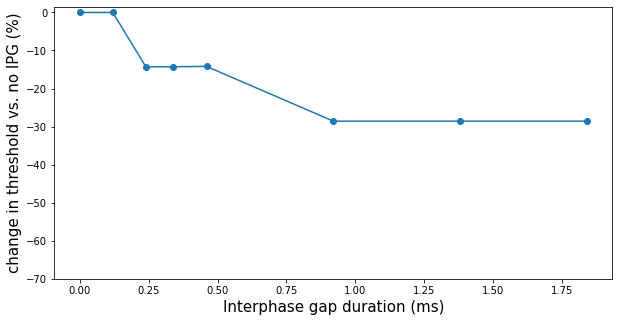

In [91]:
threshold_current = np.array([87.5, 87.5, 75.0, 75.0, 75.09765625, 62.5, 62.5, 62.5])
threshold_change = (threshold_current - threshold_current[0])/threshold_current[0]*100
plt.figure(figsize=(10,5))
plt.plot(x, threshold_change, '-o')
plt.ylim(bottom=-70)
# plt.legend(fontsize=15)
plt.ylabel("change in threshold vs. no IPG (%)", fontsize=15)
plt.xlabel("Interphase gap duration (ms)", fontsize=15)
plt.rcParams['figure.dpi'] = 300


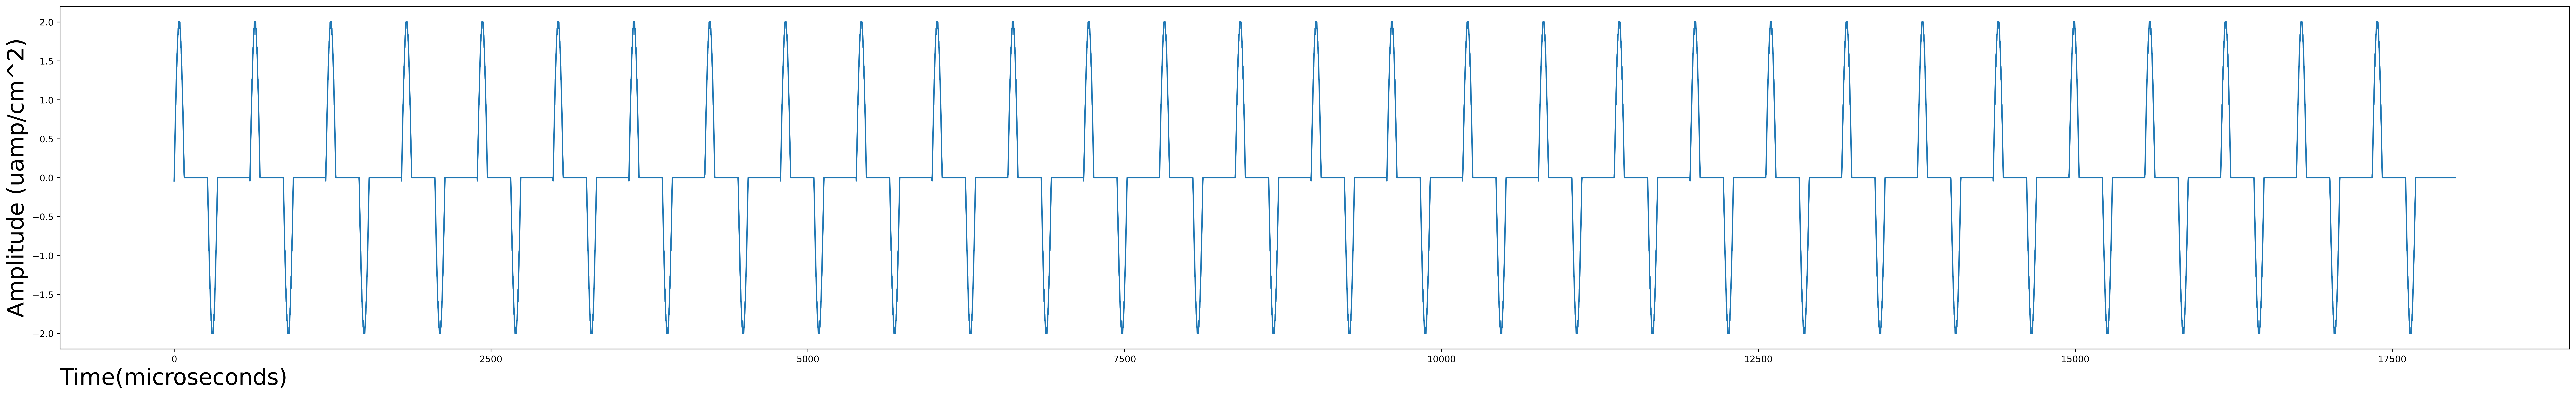

1

In [118]:
stim_to_spikes(2, 1.84)

In [96]:
matplotlib.rcParams['figure.figsize'] = [50, 7]
plt.rcParams['figure.dpi'] = 400


Text(0.5, 0, 'Interphase gap duration (ms)')

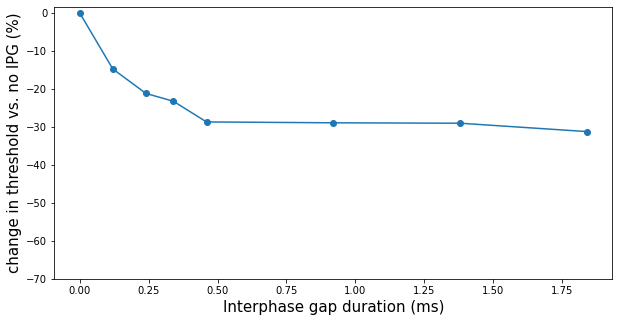

In [23]:
x = np.array([0, 0.12, 0.24,0.34,0.46,0.92,1.38,1.84])
threshold_current = np.array([3.544921875,3.0224609375,2.79388427734375,2.7204132080078125,2.5275516510009766, 2.51953125,2.515625, 2.4375])
threshold_change = (threshold_current - threshold_current[0])/threshold_current[0]*100
plt.figure(figsize=(10,5))
plt.plot(x, threshold_change, '-o')
plt.ylim(bottom=-70)
# plt.legend(fontsize=15)
plt.ylabel("change in threshold vs. no IPG (%)", fontsize=15)
plt.xlabel("Interphase gap duration (ms)", fontsize=15)